# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [1]:
from llm_v2 import LLMClient

We can declare global definitions that will be useful for any question that needs them.

In [2]:
definitions = [
    "Total Order Value is defined as the sum of extended_price * (1 - discount).",
    "Aggregate Revenue is defined as the sum of LineItem_ExtendedPrice minus the sum of LineItem_Discount.",
    "Average Revenue per Ship Date is defined as the sum of revenue divided by the count of distinct ship dates.",
    "Partial Revenue is defined as quantity * extended_price * (1 - discount).",
    "Profit is defined as revenue minus cost."
]

Then we initialize the client.

In [3]:
client = LLMClient(definitions=definitions)

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: An explanation of how the model solved the query.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide and example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.

---
## First query

Ask method asks a simple query (no discourse mode)

In [4]:
result = client.ask("Give me the name of all the suppliers from the United States")

# Find suppliers located in the United States
us_suppliers = nations.WHERE(name == "UNITED STATES").suppliers.CALCULATE(
    supplier_name=name
)


After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [13]:
print(result.base_prompt)

<task_description>
You are an AI assistant tasked with converting natural language descriptions into PyDough code snippets. Your goal is to generate accurate and efficient PyDough code that can execute the requested database operations based on the provided natural language description. 
</task_description>

<context>
To assist you in this task, you will be provided with the following context:

1. **PyDough Reference File**  
This file contains the core concepts, functions, and syntax of the PyDough language. It serves as a reference for understanding the PyDough syntax and structure.

{script_content}

2. **Database Structure Reference File**  
This file outlines the database schema, collections, fields, and relationships. It provides information about the underlying data structure and organization.

{database_content}

3. **Examples for Context**  
Here are some examples of PyDough code snippets along with their corresponding natural language questions. These examples can help contex

We can also ask for the for the **pydough code** directly.

In [5]:
print(result.code)

# Find suppliers located in the United States
us_suppliers = nations.WHERE(name == "UNITED STATES").suppliers.CALCULATE(
    supplier_name=name
)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [6]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    s_name AS name,
    s_nationkey AS nation_key
  FROM main.SUPPLIER
)
INNER JOIN (
  SELECT
    key
  FROM (
    SELECT
      n_name AS name,
      n_nationkey AS key
    FROM main.NATION
  )
  WHERE
    name = 'UNITED STATES'
)
  ON nation_key = key


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [6]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get an **explanation** of how the model solved the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [7]:
print(result.full_explanation)

Okay, let's break this down step by step.

1.  **Identify the Goal:** We need to find the names of suppliers located in the "UNITED STATES".
2.  **Locate the Data:**
    *   Supplier names are in the `suppliers` collection (`name` field).
    *   Supplier locations (nations) are linked via the `nation` sub-collection within `suppliers`, or by filtering the `nations` collection first.
    *   Nation names are in the `nations` collection (`name` field).
3.  **Determine the Relationship:** A supplier belongs to a nation. We can access this relationship either from the supplier (`supplier.nation`) or from the nation (`nation.suppliers`).
4.  **Formulate the Query Strategy:** The most efficient way is usually to filter the higher-level entity first. In this case, we can filter the `nations` collection to find the "UNITED STATES" and then access its associated suppliers.
5.  **Translate to PyDough:**
    *   Start with the `nations` collection.
    *   Filter for the nation named "UNITED STA

We can also check the original natural language **question** that was asked.

In [18]:
print(result.original_question)

Give me the name of all the suppliers from the United States


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [19]:
print(result.cheat_sheet)

## **PYDOUGH CHEAT SHEET**  
This cheat sheet is a context for learning how to create PyDough code. You must follow all the written rules. Each section represents important features and rules to keep in mind when developing PyDough code. 

### **GENERAL RULES**: 

  - This is NOT SQL, so don't make assumptions about its syntax or behavior.

  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - If a query does not specify an specific year, and want that you calculate for all the year, for example “compare year over year”, then the requested calculation must be performed for each year available in TPC: 1995, 1996, 1995 and 1998. You need to use SINGULAR function to call every year in the final result. 

  - If you need to use an attribute of a previous collection, you must have calculated the attribute using CALCULATE.

  - CALCULATE ONLY supports singular expressions. If you need to use plural sub-colle

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

To try to correct a response with execution problems in PyDough, we can use the `correct()` method. 

In [20]:
result = client.ask("For each of the 5 largest part sizes, find the part of that size with the highest retail price")

print(result.full_explanation)

top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    part_with_highest_price=part_group.TOP_K(1, by=retail_price.DESC())
)
Okay, let's break this down into smaller parts.

1.  Find the 5 largest part sizes.
2.  For each of those sizes, find the part with the highest retail price.

Here's the PyDough code:

```python
top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    part_with_highest_price=part_group.TOP_K(1, by=retail_price.DESC())
)
```

Explanation:

1.  `top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())`: This line selects the top 5 largest part sizes along with their retail prices.
2.  `PARTITION(top_5_sizes, name='part_group', by=size)`: This partitions the `top_5_sizes` collect

If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [21]:
print(result.exception)

Traceback (most recent call last):
  File "/home/gerald8525/repositories/text2pydough/workbench/AAraya/dev/llm_v2.py", line 175, in get_pydough_sql
    result_sql = pydough.to_sql(last_variable)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/evaluation/evaluate_unqualified.py", line 130, in to_sql
    qualified: PyDoughQDAG = qualify_node(node, graph, config)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 835, in qualify_node
    return qual.qualify_node(
           ^^^^^^^^^^^^^^^^^^
  File "/home/gerald8525/anaconda3/envs/aisuite_deepseek/lib/python3.12/site-packages/pydough/unqualified/qualification.py", line 786, in qualify_node
    answer = self.qualify_calculate(unqualified, context, is_child)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [22]:
corrected_result = client.correct(result)

top_5_sizes = parts.CALCULATE(size=size, retail_price=retail_price).TOP_K(5, by=size.DESC())

result = PARTITION(top_5_sizes, name='part_group', by=size).CALCULATE(
    size=size,
    highest_price=MAX(part_group.retail_price)
).part_group.CALCULATE(
    part_with_highest_price=parts.WHERE(size == size).WHERE(retail_price == highest_price).name
)


To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [10]:
print(corrected_result.full_explanation)

Okay, I understand the error and the goal. The error "Unrecognized term of simple table collection 'parts' in graph 'TPCH': 'parts'" indicates that you're trying to use the collection `parts` as a term within the `PARTITION` function, which is not allowed. The `by` parameter in `PARTITION` should only contain expressions, not collections. Also, the logic was not correct, you don't need to partition.

Here's the corrected PyDough code:

```python
top_5_sizes = parts.CALCULATE(part_size=size, part_retail_price=retail_price).TOP_K(5, by=size.DESC()).CALCULATE(size=size, max_price_part=retail_price).TOP_K(5, by=size.DESC())
```

Explanation:

1.  **`parts.CALCULATE(part_size=size, part_retail_price=retail_price)`**: This line selects the `parts` collection and creates new fields `part_size` and `part_retail_price` to store the size and retail price of each part.
2.  **`.TOP_K(5, by=size.DESC())`**: This selects the top 5 parts based on their `size` in descending order.
3.  **`.CALCULATE(si

---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [8]:
result = client.ask("Give me all the order prices, name the column total_price.")

result.df

# Select the total price for all orders
all_order_prices = orders.CALCULATE(
    total_price=total_price
)


,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


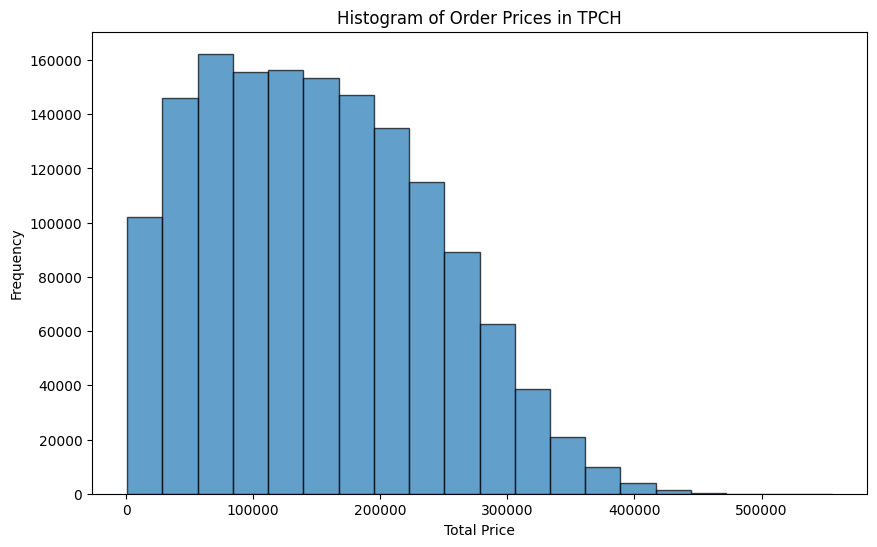

In [9]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

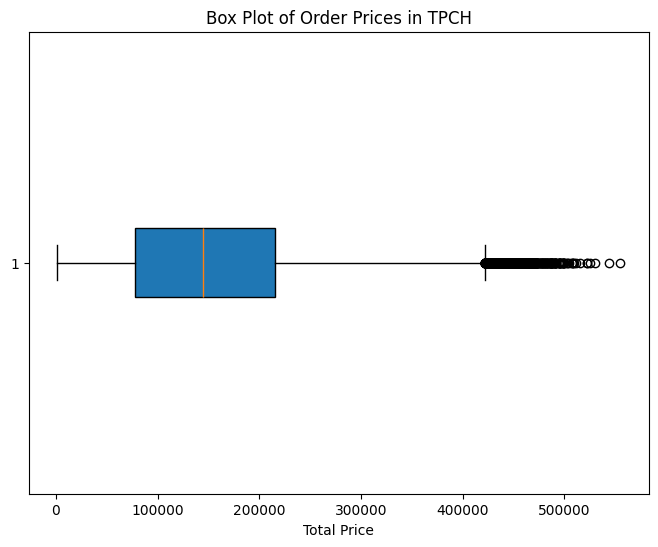

In [10]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [11]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Now, this can be used to analyse the PyDough code that was first generated.

{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


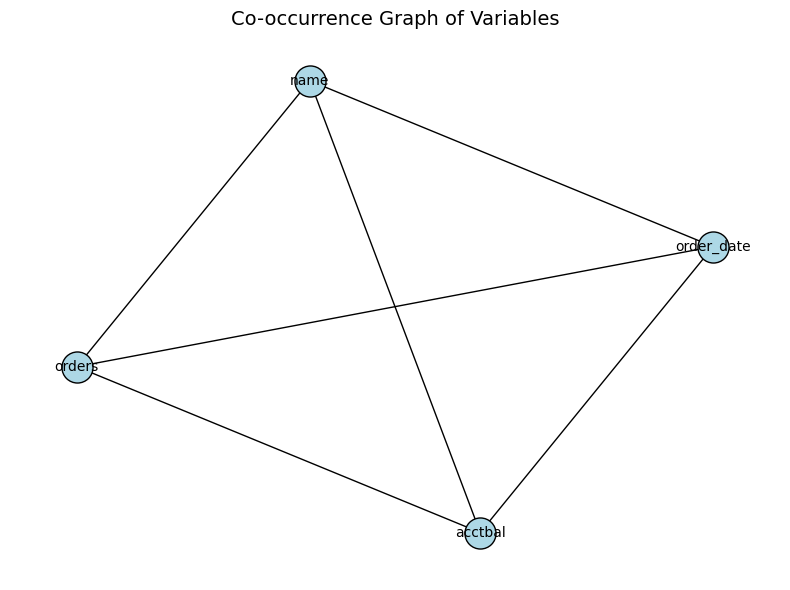

In [12]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)

---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [13]:
query = "Find the names of all customers and the number of their orders placed in 1995 in Europe."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

# Find European customers and COUNT their orders from 1995
european_customers_1995_orders = customers.WHERE(nation.region.name == "EUROPE").CALCULATE(
    customer_name=name,
    order_count_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)
```python
# Find European customers and count their orders from 1995
european_customers_1995_orders = customers.WHERE(nation.region.name == "EUROPE").CALCULATE(
    customer_name=name,
    order_count_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)
```

**Explanation:**

1.  **`customers.WHERE(nation.region.name == "EUROPE")`**: This starts with the `customers` collection and filters it to include only those customers whose associated `nation` belongs to the `region` named "EUROPE".
2.  **`.CALCULATE(...)`**: For each of the filtered European customers, this calculates new fields:
    *   **`customer_name=name`**: Selects the `name` of the customer and assigns it to the `customer_name` field in the output.
    *   **`order_count_1995=COUNT(o

,customer_name,order_count_1995
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [14]:
result2 = client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result2.full_explanation)
result2.df.head()

# Find European customers, calculate their 1995 order COUNT and account balance
european_customers_info = customers.WHERE(nation.region.name == "EUROPE").CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    order_count_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)

# Filter those customers with account balance > 700 and at least one order in 1995
filtered_european_customers = european_customers_info.WHERE(
    (account_balance > 700) & (order_count_1995 >= 1)
)

# Sort the filtered customers by the number of orders in descending order
# and select only the customer name and order COUNT
sorted_customers = filtered_european_customers.ORDER_BY(
    order_count_1995.DESC()
).CALCULATE(
    customer_name=customer_name,
    order_count_1995=order_count_1995
)
```python
# Find European customers, calculate their 1995 order count and account balance
european_customers_info = customers.WHERE(nation.region.name == "EUROPE").CALCULATE(
    customer_name=name,
    account_bal

,customer_name,order_count_1995
0,Customer#000107440,12
1,Customer#000014920,11
2,Customer#000079606,11
3,Customer#000108496,11
4,Customer#000009019,10


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [15]:
query = "List customers who ordered in 1996 but not in 1997 with a total spent of over $1000."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

customers_filtered = customers.WHERE(
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) &
    (HASNOT(orders.WHERE(YEAR(order_date) == 1997)) == 1) &
    (SUM(orders.total_price) > 1000)
).CALCULATE(
    customer_key=key,
    customer_name=name
)
Okay, let's break down the request and generate the PyDough code step by step.

**Analysis:**

1.  **Goal:** Find customers who meet three criteria:
    *   Placed at least one order in 1996.
    *   Placed *no* orders in 1997.
    *   Have a total spending (across all their orders) exceeding $1000.
2.  **Starting Collection:** We need information about customers and their orders, so `customers` is the appropriate starting point.
3.  **Conditions:**
    *   **Ordered in 1996:** We need to check if the `orders` sub-collection contains any order where `YEAR(order_date) == 1996`. The `HAS()` function is suitable here.
    *   **Not ordered in 1997:** We need to check if the `orders` sub-collection contains *no* orders where `YEAR(order_date)

,customer_key,customer_name
0,5,Customer#000000005
1,17,Customer#000000017
2,20,Customer#000000020
3,31,Customer#000000031
4,38,Customer#000000038


**Follow up**: Now, include the number of months since the last order and sort by total spent, highest first.

In [16]:
result2 = client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result2.full_explanation)
result2.df.head()

# Step 1: Calculate intermediate data for each customer
customer_data = customers.CALCULATE(
    # Keep original key/name for later use
    _key=key,
    _name=name,
    # Calculate flags for filtering
    _has_order_1996=HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1,
    _has_order_1997=HAS(orders.WHERE(YEAR(order_date) == 1997)) == 1,
    # Calculate total spending for filtering and output
    _total_spent=SUM(orders.total_price),
    # Find the date of the last order for the DATEDIFF calculation
    _last_order_date=MAX(orders.order_date)
)

# Step 2: Filter customers based on the criteria
customers_filtered = customer_data.WHERE(
    (_has_order_1996 == 1) &  # Ordered in 1996
    (_has_order_1997 == 0) &  # Did NOT order in 1997
    (_total_spent > 1000)     # Total spent > $1000
)

# Step 3: Calculate the final fields, including months_since_last_order, and sort
customers_final_sorted = customers_filtered.CALCULATE(
    customer_key=_key,
    customer_name=_name,
    total_spe

,customer_key,customer_name,total_spent,months_since_last_order
0,1948,Customer#000001948,5614411.17,321
1,47401,Customer#000047401,5262679.14,323
2,94354,Customer#000094354,5234152.55,320
3,120877,Customer#000120877,5200194.28,320
4,12595,Customer#000012595,4973507.88,320


### Sales Performance

### 3. Find the region with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [21]:
client.add_definition("Revenue is defined as the sum of quantity * extended_price * (1 - discount) * (1 + tax).")

The new definition has been added to the definition list.


In [22]:
query = "Find the region with the highest revenue in 1996."

result = client.ask(query)

print(result.full_explanation)
result.df.head()

# Calculate revenue for each line item first, as per the definition.
# Note: We need an intermediate CALCULATE on lines because revenue involves multiple fields from the same line item.
revenue_per_line = lines.CALCULATE(
    line_revenue=quantity * extended_price * (1 - discount) * (1 + tax)
)

# Calculate total revenue per region for orders placed in 1996.
region_revenue_1996 = regions.CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(
             # Calculate revenue for each line within the aggregation context
             line_revenue = quantity * extended_price * (1 - discount) * (1 + tax)
        ).line_revenue # Access the calculated line_revenue for SUM
    )
)

# Find the region with the highest total revenue in 1996.
top_region_revenue_1996 = region_revenue_1996.TOP_K(1, by=total_revenue.DESC())
Okay, let's break down the request and generate the PyDough code step by step.

1.  **Goal:** F

,region_name,total_revenue
0,EUROPE,2.360143e+11


**Follow up**: Can you compare it now year over year **in that region**?

In [23]:
result2 = client.discourse(result, "Can you compare it now year over year in that region?")

print(result2.full_explanation)
result2.df.head()

# Calculate EUROPE's revenue for 1995
europe_revenue_1995 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1995).lines.CALCULATE(
            # Calculate revenue per line item according to the definition
            line_revenue=quantity * extended_price * (1 - discount) * (1 + tax)
        ).line_revenue # SUM the calculated line_revenue
    )
)

# Calculate EUROPE's revenue for 1996
europe_revenue_1996 = regions.WHERE(name == "EUROPE").CALCULATE(
    region_name=name,
    total_revenue=SUM(
        nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.CALCULATE(
            # Calculate revenue per line item according to the definition
            line_revenue=quantity * extended_price * (1 - discount) * (1 + tax)
        ).line_revenue # SUM the calculated line_revenue
    )
)

# Calculate EUROPE's revenue for 1997
europe_revenue_1997 = regions.WHERE(name == "EUROPE").CALCULAT

,region_name,revenue_1995,revenue_1996,revenue_1997,revenue_1998
0,EUROPE,2.345751e+11,2.360143e+11,2.314001e+11,1.385839e+11


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

- Highlights ranking queries, customer segmentation, and purchasing trends. 

In [19]:
query = "Which 10 customers purchased the highest quantity of products during 1998?."

result = client.ask(query)

print(result.full_explanation)
result.df

# Find the top 10 customers by total quantity purchased in 1998
top_10_customers_1998_quantity = customers.CALCULATE(
    # Select the customer's name
    customer_name=name,
    # Calculate the total quantity of items ordered by the customer in 1998
    total_quantity_1998=SUM(
        # Access the customer's orders
        orders
        # Filter orders placed in 1998
        .WHERE(YEAR(order_date) == 1998)
        # Access the line items for those orders
        .lines
        # Get the quantity from each line item
        .quantity
    )
# Select the top 10 customers based on the calculated total quantity in descending order
).TOP_K(10, by=total_quantity_1998.DESC())
Okay, let's break down the request "Which 10 customers purchased the highest quantity of products during 1998?" step by step and generate the PyDough code.

1.  **Identify the Goal:** We need to find the top 10 customers based on the total quantity of items they ordered in the year 1998.
2.  **Starting Collection:** T

,customer_name,total_quantity_1998
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058
5,Customer#000102295,1029
6,Customer#000027970,995
7,Customer#000053383,994
8,Customer#000099025,988
9,Customer#000137437,987


**Follow up**: Now return the sum of only the products that have "green" on the product name.

In [20]:
result2 = client.discourse(result, """Now take into account only the products that have "green" in their name""")

print(result2.full_explanation)
result2.df

# Find the top 10 customers by total quantity of "green" products purchased in 1998
top_10_customers_green_products_1998 = customers.CALCULATE(
    # Select the customer's name
    customer_name=name,
    # Calculate the total quantity of "green" items ordered by the customer in 1998
    total_green_quantity_1998=SUM(
        # Access the customer's orders
        orders
        # Filter orders placed in 1998
        .WHERE(YEAR(order_date) == 1998)
        # Access the line items for those orders
        .lines
        # Filter line items WHERE the associated part name CONTAINS "green"
        .WHERE(CONTAINS(part.name, "green"))
        # Get the quantity from each filtered line item
        .quantity
    )
# Select the top 10 customers based on the calculated total quantity in descending order
).TOP_K(10, by=total_green_quantity_1998.DESC())
```python
# Find the top 10 customers by total quantity of "green" products purchased in 1998
top_10_customers_green_products_1998 = customers.

,customer_name,total_green_quantity_1998
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172
5,Customer#000009139,171
6,Customer#000099187,170
7,Customer#000024817,164
8,Customer#000112678,162
9,Customer#000072490,158
